In [167]:
import cPickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

import xgboost as xgb

from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc

from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

stemmer = SnowballStemmer("english")

In [122]:
# See nice example from 
# https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py

# Also RunMutliclassOneVRest

In [168]:
#from http://stackoverflow.com/questions/26126442/combining-text-stemming-and-removal-of-punctuation-in-nltk-and-scikit-learn


stemmer = SnowballStemmer("english")

def stem_tokens(tokens, stemmer):
    stemmed=[]
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

    

In [169]:
df = pickle.load(open('../Data/labeledhate_5cats.p', 'rb'))

In [170]:
X = df.body
y = df.label
classes=['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']

In [171]:
# Relabel the output, integers [0-4], for xgboost

# e.g. for 0: df.ix[(df.label=='NotHate'),'label'] = '0'
for ind in range(len(classes)):
    y[(y==classes[ind])] = int(ind)



In [172]:
n_classes = len(classes)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [68]:
# Had some problems with label_binarize--wanted to probe type_of_target in this cell to see if that was the issue
# (It was.)
from sklearn.utils.multiclass import type_of_target
type_of_target(y_test.astype(int))

'multiclass'

In [174]:
# Binarize ylabel (y_test), so we can call multiclass roc plot
# Need to cast y_test as an int.
ylabel_bin = label_binarize(y_test.astype(int), classes=[0,1,2,3,4],sparse_output=False)

In [96]:
np.array(y_test).shape

(473426,)

In [76]:
# y_test

#### Use Count Vectorizer

In [ ]:
# Model notes:
#  CV with 10,000 features, no tokenizing, english stop words --> AUC = 0.644
#  CV with 20,000 features, no tokenizing, english stop words --> AUC = 0.644
#  CV with 5,000 features, no tokenizing, english stop words --> AUC = 0.642
#  CV with 5,000 features, no tokenizing, english stop words, eta = 0.3 --> 0.666
#  CV with 5,000 features, no tokenizing, english stop words, eta = 0.9 --> 0.710
# Assuming english stop words
#  CV with 5,000 features, no tokenizing, max_depth = 4 , eta = 0.9 --> 0.687  (stick to max depth = 6)



In [215]:
countv = CountVectorizer(decode_error = 'ignore', stop_words = 'english',max_features=5000, tokenizer=None)
# countv = CountVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=5000, tokenizer=None)

In [216]:
#Training vectors
countv_fit_X_train = countv.fit_transform(X_train)
#test vectora
countv_fit_X_test = countv.transform(X_test)

In [116]:
y_train.value_counts()

0    708151
1    222053
2    133035
3     37368
4      4052
Name: label, dtype: int64

In [217]:
xg_train = xgb.DMatrix(countv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(countv_fit_X_test, label=y_test)

In [222]:
# Set up xboost parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.9
param['max_depth'] = 4
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 5


watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist );
# get prediction
pred = bst.predict( xg_test );

# #reshape y_test
# ytestlen = y_test.shape[0]
# y_test.reshape( ytestlen, 1 )

print ('predicting, classification error=%f' % (sum( int(pred[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

[0]	train-merror:0.314597	test-merror:0.312704
[1]	train-merror:0.307330	test-merror:0.305186
[2]	train-merror:0.300204	test-merror:0.298412
[3]	train-merror:0.295704	test-merror:0.293991


predicting, classification error=0.291256


[4]	train-merror:0.292797	test-merror:0.291256


In [223]:
# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))

[0]	train-merror:0.314597	test-merror:0.312704
[1]	train-merror:0.307330	test-merror:0.305186
[2]	train-merror:0.300204	test-merror:0.298412
[3]	train-merror:0.295704	test-merror:0.293991


predicting, classification error=0.291256


[4]	train-merror:0.292797	test-merror:0.291256


<IPython.core.display.Javascript object>


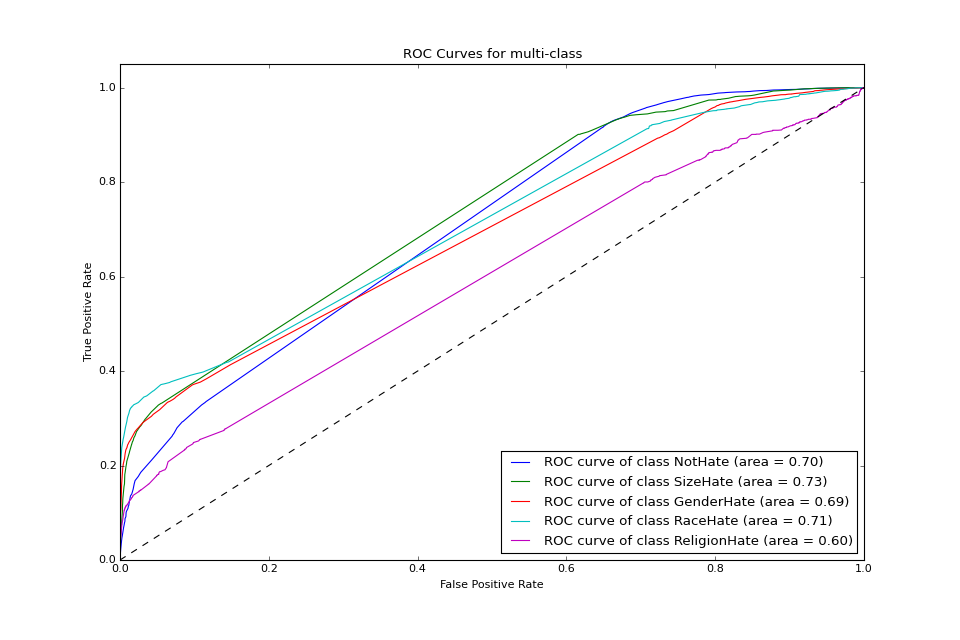

average AUC: 0.687091573998


In [224]:
createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))


In [221]:
top_features(bst.get_fscore(), n=30)

[('f1726', 36),
 ('f3263', 31),
 ('f4890', 24),
 ('f2051', 21),
 ('f4923', 15),
 ('f2659', 14),
 ('f1975', 14),
 ('f3034', 13),
 ('f1935', 12),
 ('f1933', 12),
 ('f1931', 12),
 ('f1734', 12),
 ('f539', 11),
 ('f4872', 11),
 ('f3033', 11),
 ('f2482', 11),
 ('f2480', 11),
 ('f540', 10),
 ('f507', 10),
 ('f1907', 10),
 ('f1391', 10),
 ('f4891', 9),
 ('f4638', 9),
 ('f4106', 9),
 ('f2515', 9),
 ('f1763', 9),
 ('f4524', 8),
 ('f682', 6),
 ('f4107', 6),
 ('f3912', 6)]

### Use TF-IDF

In [ ]:
# Model notes
#  TFIDF with english stop words, 10,000 features, no tokenizing --> avg AUC = .6436
#  TFIDF with english stop words, 20,000 features, no tokenizing --> avg AUC = .6441
#  TFIDF with english stop words, 1000 features, no tokenizing --> avg AUC = .6349
#  TFIDF with english stop words, 50,000 features, no tokenizing --> avg AUC = .6447
#  TFIDF with english stop words, 5000 features, no tokenizing --> avg AUC = .6416
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.35 --> avg AUC = .676
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.4 --> avg AUC = .676
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.5 --> avg AUC = .685
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.7 --> avg AUC = .702
#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.9 --> avg AUC = .712
#  TFIDF with english stop words, 10,000 features, no tokenizing, eta = 0.9 --> avg AUC = .715
#  TFIDF with english stop words, 5,000 features, WITH tokenizing/snowball, eta = 0.9 --> avg AUC = .735

#  TFIDF with english stop words, 5000 features, no tokenizing, eta = 0.95 --> avg AUC = .712 --> use eta=0.9





In [211]:
tfidfv = TfidfVectorizer(decode_error = 'ignore', stop_words = 'english', max_features=5000, tokenizer=None)

In [212]:
#Training vectors
tfidfv_fit_X_train = tfidfv.fit_transform(X_train)
#test vectora
tfidfv_fit_X_test = tfidfv.transform(X_test)

In [213]:
xg_train = xgb.DMatrix(tfidfv_fit_X_train, label=y_train)
xg_test = xgb.DMatrix(tfidfv_fit_X_test, label=y_test)
# Set up xboost parameters
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.90
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 5


watchlist = [ (xg_train, 'train'), (xg_test, 'test') ]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist );
# get prediction
pred = bst.predict( xg_test );

# #reshape y_test
# ytestlen = y_test.shape[0]
# y_test.reshape( ytestlen, 1 )

print ('predicting, classification error=%f' % (sum( int(pred[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))
# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( y_test.shape[0], 5 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_test.iloc[i] for i in range(len(y_test))) / float(len(y_test)) ))


[0]	train-merror:0.306409	test-merror:0.304884
[1]	train-merror:0.298475	test-merror:0.297037
[2]	train-merror:0.292203	test-merror:0.291006
[3]	train-merror:0.287473	test-merror:0.286674
[4]	train-merror:0.282943	test-merror:0.282747
[0]	train-merror:0.306409	test-merror:0.304884
[1]	train-merror:0.298475	test-merror:0.297037
[2]	train-merror:0.292203	test-merror:0.291006
[3]	train-merror:0.287473	test-merror:0.286674
[4]	train-merror:0.282943	test-merror:0.282747


predicting, classification error=0.282747
predicting, classification error=0.282747


<IPython.core.display.Javascript object>


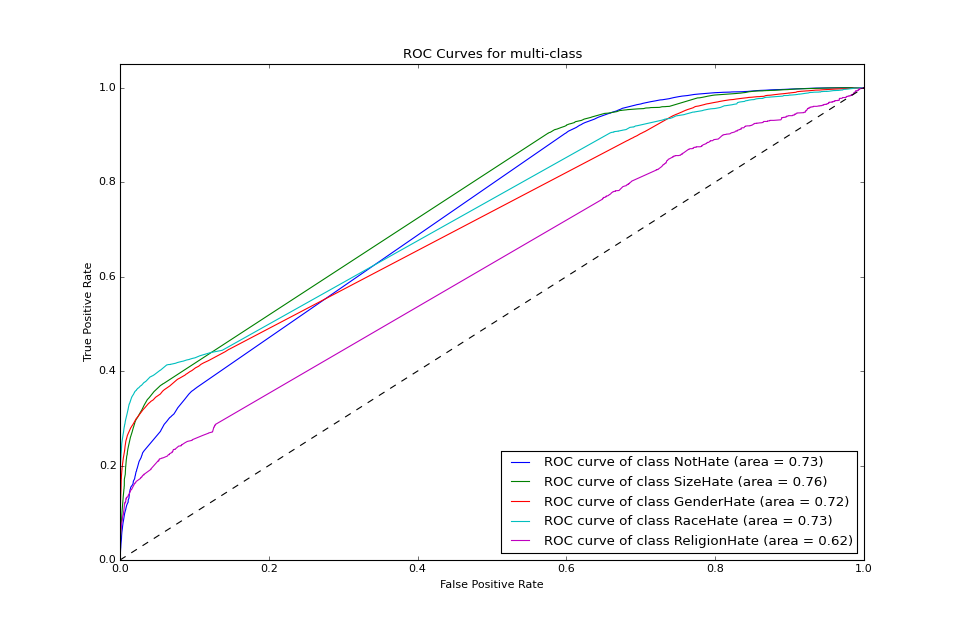

average AUC: 0.711991417256


In [214]:
createmulticlassROC(classes, ylabel_bin, yprob)
print("average AUC: {0}").format(roc_auc_score(ylabel_bin, yprob))


In [236]:
top_features(bst.get_fscore(), n=30)

[('f1726', 18),
 ('f3034', 12),
 ('f2051', 12),
 ('f4872', 10),
 ('f2480', 10),
 ('f4890', 8),
 ('f1935', 8),
 ('f1933', 8),
 ('f3263', 7),
 ('f3033', 7),
 ('f1975', 7),
 ('f1391', 7),
 ('f2482', 6),
 ('f1734', 6),
 ('f1691', 6),
 ('f1931', 5),
 ('f540', 4),
 ('f4891', 4),
 ('f4106', 4),
 ('f2711', 4),
 ('f1907', 4),
 ('f568', 3),
 ('f507', 3),
 ('f4923', 3),
 ('f4524', 3),
 ('f4042', 3),
 ('f2848', 3),
 ('f2437', 3),
 ('f2230', 3),
 ('f1945', 3)]

<IPython.core.display.Javascript object>


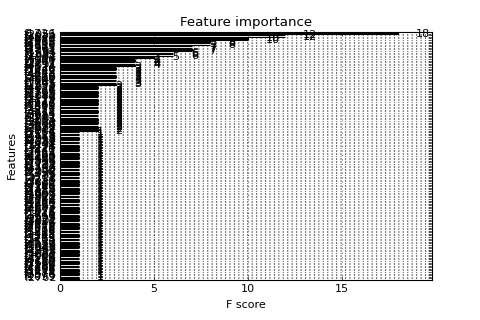

In [237]:
%matplotlib notebook
#figure(figsize(12,8))
xgb.plot_importance(bst)

In [227]:
# Back out important features
dicta = tfidfv.vocabulary_

In [228]:
dictb = dict ( (v,k) for k, v in dicta.items() )

In [242]:
dictb[4872]  #put in the feature # here to get the word back

u'weight'

In [137]:
# write function to grab the feature importances & show top ~20

def top_features(d, n=20):
    '''
    Function to show the top n important features & their scores.
    The get_fscore method in xgboost returns a dictionary of features & a number.
    Get the top n features with the highest scores
    
    d is a dictionary (from get_fscore method in xgboost)
    '''
    
    featureslist = []
    
    for k, v in sorted(d.iteritems(), reverse=True, key=lambda (k,v): (v,k)):
        featureslist.append((k,v))
    
    return featureslist[:n]
    
 

In [80]:
def createmulticlassROC(classes, y_test, y_score):
    '''
    Function to create & plot ROC curve & associated areas
    Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

    Inputs: classes: a list of classes
            y_test: the test labels, binarized into columns
            y_score: the predicted probabilities for each class.   
                (e.g. y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test) )
    '''
    
    # Compute ROC curve and ROC area for each class
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize = (12,8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for multi-class')
    plt.legend(loc="lower right")
    plt.show()